<a href="https://colab.research.google.com/github/Chinmayak1197/SCARA-Robot/blob/master/CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


# Leaves Diseases Detection on Potato Plants using CNN
# 1. Data Collection 
# 2. Model Building 
# 3. ML Ops
# 4. Development (GCP)

#Early Blight: caused by fungus 
#Late BLight : caused by micro-organism 
#Treatment are different so the farmer should know what is the problem before applying solution to the plant 
#Atliq agriculture is working on the same project 
#Mobile Application which detects plant is healthy or not 

# Data Collection -> Data Cleaning(tf dataset and data augmentation) -> model building(CNN)
# export the train model on the test
# will serve on tf.serving and will be served to fast API 
# Website(react JS)
# Mobile app development: converted the exported flot model to tf.light model(quantization model)
#deploy to google cloud and aws function-> which can be served to mobile application 

#Model Building :tensorflow, CNN, data augmentation and tf.dataset
# Backend Server : tf.serving , fast API 
# Model Optimization: Quantization and tensorflow lite
#Frontend and deployment : React JS, React native and Deployment to GCP 


#Download dataset into tensorflow data input pipeline 
import tensorflow as tf 
from tensorflow.keras import models , layers 
import matplotlib.pyplot as plt 

#Tensorflow Input Pipeline 
#Harddisk -> RAM (Convert to numpy array)
#When we have more than 1000 images, like around 1 million images and considering 8GB as our computer RAM, 
#We load the images in batches (Special data structure)
#Special Data structure: tf.data.Dataset
#First clearning is done, as image can be blurry -> to use filter function (tf_dataset.filter)
#the values are from 0 -255, have to scale the images by dividing by 255. (SCALING)(tf_dataset.map)
#All this pre-processing can be done in single line of code:
#tf.data.Dataset.list_files('images/*').map(process_img).filter(filter_func).map(lambda x:x/255)
#2nd step is training the model 
# model.fit(tf.dataset)


Mounted at /content/drive


In [ ]:
# Creating dataset from python list
# import tensorflow as tf 
# daily = [21, 22, -100 , 31, -1, 32, 34, 31]
# tf_dataset = tf.data.Dataset.from_tensor_slices(daily)
# tf_dataset

# for sales in tf_dataset.as_numpy_iterator():
#     print(sales)
    
# # for sale in tf_dataset.take(3):
# #     print(sale.numpy())

# tf_dataset = tf_dataset.filter(lambda x: x>0)
# # for sales in tf_dataset.as_numpy_iterator():
# #     print(sales)

# tf_dataset = tf_dataset.map(lambda x:x*72)
# for sales in tf_dataset.as_numpy_iterator():
#     print(sales)
    
# tf_dataset = tf_dataset.shuffle(3)
# # Creates a window of 3 

# # Batching 
# for sales in tf_dataset.batch(2):
#     print(sales.numpy())
    
# 1-Single Line 
# tf_dataset = tf_dataset.filter(lambda x: x>0).map(lambda y:y*72).shuffle(3).batch(2)
# for sales in tf_dataset.as_numpy_iterator():
#     print(sales)

Found 2152 files belonging to 3 classes.
(32, 256, 256, 3)
[2 0 1 1 1 1 2 1 0 0 2 0 1 1 0 1 0 0 1 2 0 0 1 0 1 0 0 1 0 0 1 1]


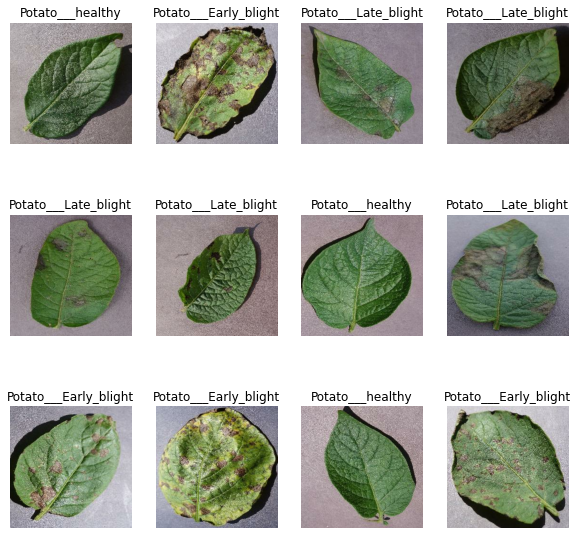

In [ ]:
#Constants 
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

# To load the image data from the directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Deep Learning /Dataset',
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

#Folder names are class names 
class_names = dataset.class_names
class_names

#Length of dataset
#Every element is batch of 32 images: 68*32 = Around 2152 images
len(dataset)


#To change the image area:
plt.figure(figsize = (10,10))
#Explore 1 batch 
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    
    #To print first image of the bacth of 32 and tendor-> numpy 
#     print(image_batch[0].numpy())
    for i in range(12):
#     To Visualize the image and convert flost into int:
#         To make a subplot otherwise only one will be shown 
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
#32 images of 256*256 and 3 Channels(RGB)
#0: Early_blight
#1: late_blight
#2: healthy

In [ ]:
#Splitting the dataset:
# 80% -> training 
# 10% -> validation, 10% -> test 
# In Sklearn, we have train-test split, which is not there in tensorflow
# dataset.take(n) arr[:n], dataset.skip() arr[n:]is used in tensorflow

#HARDCODE

train_size = 0.8
# len(dataset)*train_size
train_ds = dataset.take(54)
test_ds = dataset.skip(54)
# len(test_ds)
val_ds = test_ds.take(6)
# len(val_ds)
test_ds = test_ds.skip(6)
# len(test_ds)

#Making a proper function for splitting the dataset
#Which return the dataset into train,test and split
def get_dataset_partitions_tf(ds , train_split=0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size =10000):
    
    ds_size = len(ds)
    if shuffle: 
        ds = ds.shuffle(shuffle_size, seed = 12) # seed is for predictibility 
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)
# len(train_ds)

# Cacheing and pre-fetching:
# Caching: Read the image from the disk and keep the iamge in the memory for the second time 
# Prefetch: if GPU is bsy training, then prefect will load nect bach on the disk which will increase performance.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

#Pre-processing 
#Resizing the image 
Resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
    
])

# # CNN -> Feature extraction (Convolution + Pooling) and Classification(Dense)
model = models.Sequential ([
#   Layers are based on trial and error 
    Resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32 , (3,3), activation = 'relu' , input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),  
    layers.Conv2D(64 , (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64 , activation = 'relu'),
    layers.Dense(3, activation = 'softmax')
# Softmax normalizes the probability of layers

])

model.build(input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE,3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)


In [ ]:
history = model.fit(
    train_ds,
    epochs = 30,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds    
)

Epoch 1/30
54/54 [==============================] - 196s 4s/step - loss: 0.4882 - accuracy: 0.8171 - val_loss: 0.4760 - val_accuracy: 0.8021
Epoch 2/30
54/54 [==============================] - 197s 4s/step - loss: 0.3884 - accuracy: 0.8559 - val_loss: 0.3526 - val_accuracy: 0.8542
Epoch 3/30
54/54 [==============================] - 194s 4s/step - loss: 0.2884 - accuracy: 0.8819 - val_loss: 0.5891 - val_accuracy: 0.8125
Epoch 4/30
54/54 [==============================] - 194s 4s/step - loss: 0.2607 - accuracy: 0.8958 - val_loss: 0.2114 - val_accuracy: 0.9219
Epoch 5/30
54/54 [==============================] - 194s 4s/step - loss: 0.1800 - accuracy: 0.9265 - val_loss: 0.1808 - val_accuracy: 0.9323
Epoch 6/30
54/54 [==============================] - 193s 4s/step - loss: 0.1374 - accuracy: 0.9462 - val_loss: 0.3212 - val_accuracy: 0.8698
Epoch 7/30
54/54 [==============================] - 193s 4s/step - loss: 0.1227 - accuracy: 0.9520 - val_loss: 0.3517 - val_accuracy: 0.8958
Epoch 8/30
54

In [ ]:
# Convolutional Neural Network 
# Representation does not matches when the picture is shifted thats why artificial neural networks are used.
# ANN disadvantage for image classification: too much computation, treats local pixel same as pixel far apart and sensitive to location of an object in an image

# Convolutional creates Feature maps
# After convolution flatten them to make a fully connected dense neural networks
# CNN -> feature extraction + classification 
#  Relu activation: brings non linearity in the function(making the negative numbers 0)
# Pooling is used to reduce the size , reduces overfitting and model is tolerant towards variants  
# Max Pooling , Average Pooling 
#Max Pooling  + CNN -> Position invariant feature detection 

# Advantage
# Connection Sparsity, location invariant detection and Parameter sharing 
# Relu -> introduces non-linearity and faster the computer

# Data augmentation for rotation and thickness 


In [ ]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 13s 876ms/step - loss: 0.2589 - accuracy: 0.9023


{'verbose': 1, 'epochs': 30, 'steps': 54}
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
[0.8171296119689941, 0.8559027910232544, 0.8819444179534912, 0.8958333134651184, 0.9265046119689941, 0.9461805820465088, 0.9519675970077515, 0.9600694179534912, 0.9467592835426331, 0.9589120149612427, 0.9589120149612427, 0.9421296119689941, 0.9652777910232544, 0.9646990895271301, 0.9629629850387573, 0.9664351940155029, 0.9461805820465088, 0.96875, 0.9774305820465088, 0.9629629850387573, 0.9675925970077515, 0.9641203880310059, 0.9652777910232544, 0.9635416865348816, 0.9745370149612427, 0.9693287014961243, 0.9774305820465088, 0.9785879850387573, 0.9710648059844971, 0.9785879850387573]
20


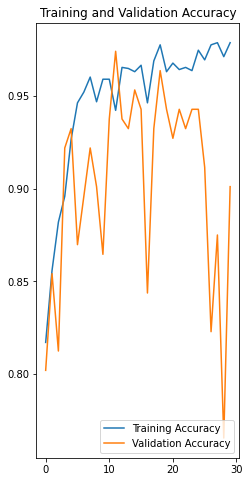

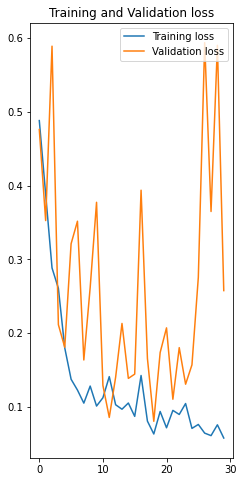

In [ ]:
scores
# python list [loss,accuracy]
print(history.params) #history parameters 
print(history.history.keys())

# Plot the accuracy
acc = history.history['accuracy']
print(acc)
print(EPOCHS)
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Accuracy Chart 
plt.figure(figsize =(8,8))
plt.subplot(1,2,1)
plt.plot(range(30), acc, label = 'Training Accuracy')
plt.plot(range(30), val_acc, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss Chart
# Loss: error in back propogation
plt.figure(figsize =(8,8))
plt.subplot(1,2,1)
plt.plot(range(30), loss, label = 'Training loss')
plt.plot(range(30), val_loss, label = 'Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')
plt.show()



first image to predict
actual label: Potato___Late_blight
1
predicted label: Potato___Late_blight


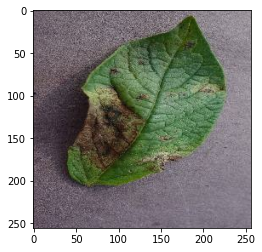

In [ ]:
import numpy as np
for image_batch, labels_batch in test_ds.take(1):

  # plt.imshow(image_batch[0].numpy().astype('uint8')) # Actual image 
  # plt.imshow(image_batch[0].numpy().astype('uint8')) # 3D Array 

  first_image = image_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy() 

  print("first image to predict")
  plt.imshow(first_image)
  print("actual label:",class_names[first_label])

  batch_prediction = model.predict(image_batch)
  print(np.argmax(batch_prediction[0]))
  print("predicted label:",class_names[np.argmax(batch_prediction[0])])
  #Gives the position of the class name 
  #Gives the predicited labels 

TypeError: ignored

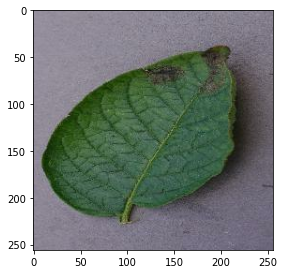

In [ ]:
# Function for predicition
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy)
  img_array = tf.expand_dims(img_array, 0 )

  predictions = model.predict(img_array)

  predictied_class = class_names(np.argmax(predictions[0]))
  confidence = round(100*(np.argmax(predictions[0],)),2)

  return predictied_class, confidence 



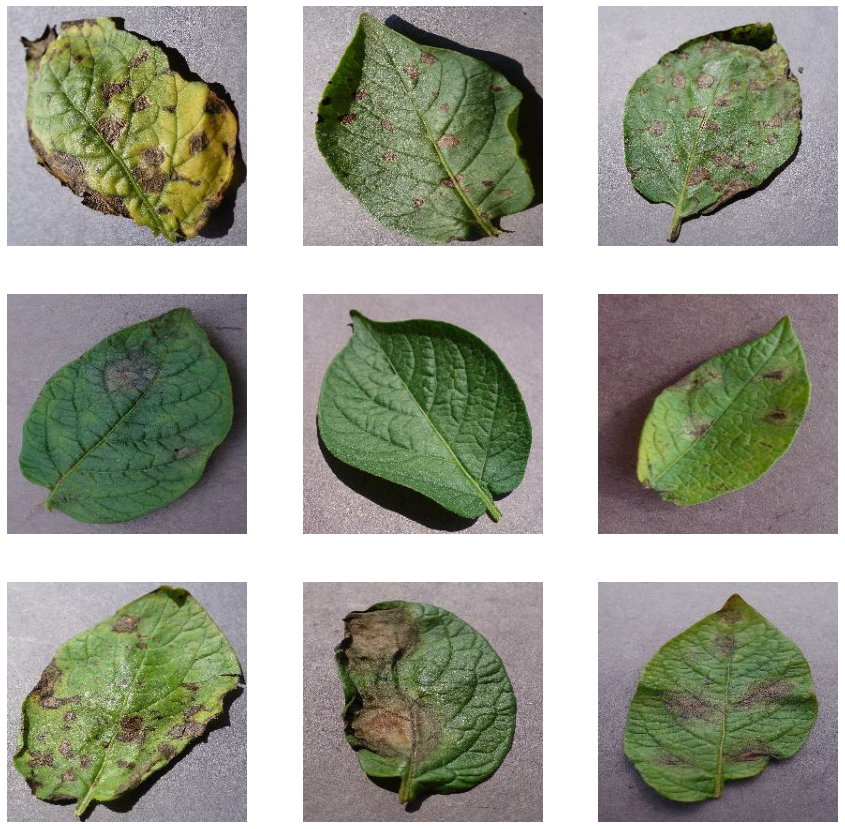

In [ ]:
plt.figure(figsize = (15,15))
import numpy as np

for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    # predicted_class, confidence  = predict(model, images[i].numpy().astype("uint8"))
    actual_class = class_names[labels[i]]

    # plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}." )
    plt.axis('off')
    

In [ ]:
# Saving the model 
import os 
os.chdir
# os.listdir('../Models')
model.version = 1
model.save(f'Models')

INFO:tensorflow:Assets written to: Models/assets
